In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '.'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Given $x_0$ and $y_0$, find such $x(t)$ and $y(t)$ : $\mathbb{R} \to \mathbb{R}$, so that

$$\frac{\mathrm{d}x}{\mathrm{d}t} = \alpha x - \beta x y$$
$$\frac{\mathrm{d}y}{\mathrm{d}t} = \delta x y - \gamma y$$
$$x(0) = x_0, \quad y(0) = y_0$$

We consider problem with following given parameters and initial values: $\alpha = 0.4, \beta = 0.1, \delta = 0.1, \gamma = 0.6$ and $x_0 = 5, y_0 = 5$ on a domain $[0, 38]$.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

We will solve this problem numerically.

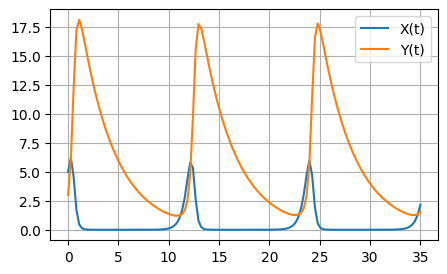

In [40]:
from scipy.integrate import solve_ivp

# We fix variables for clarity.
T = 35
alpha, beta, delta, gamma = 2.5, 0.4, 0.5, 0.3
x0, y0 = 5.0, 3.0

def lotka_volterra(t, u, alpha, beta, delta, gamma):
            x, y = u
            dx_dt = alpha * x - beta * x * y
            dy_dt = delta * x * y - gamma * y
            return [dx_dt, dy_dt]

t = torch.linspace(0, T, 128)
solution = solve_ivp(lotka_volterra, 
                        (0, T),
                        [x0, y0],
                        args=(alpha, beta, delta, gamma), 
                        t_eval=t)
x = solution.y[0]
y = solution.y[1]

fig = plt.figure(figsize=(5, 3))
plt.plot(t, x, label = 'X(t)')
plt.plot(t, y, label = 'Y(t)')
plt.grid()
plt.legend()
plt.show()

Our neural network for this task will have one input and two outputs.

In [41]:
from pinns import Domain
from pinns.samplers import ConstantSampler, RandomSampler

constraints_sampler = ConstantSampler((
    torch.tensor([[0.]]),
    torch.tensor([x0, y0])
))

domain = Domain({'t': [0, T]})
collocation_sampler = RandomSampler(domain, 2048, return_dict=False)

test_points_sampler = ConstantSampler((
    t.view(-1, 1), 
    torch.tensor([x, y]).T
    ))

In [42]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def init_loss(u, u0, t0):
    return torch.mean(torch.square(u0 - u))

def ode_loss(u, t):
    x = u[:, [0]]
    y = u[:, [1]]
    
    dX = d(x, t)
    dY = d(y, t)
    
    LdX = torch.mean(torch.square(dX - alpha * x + beta * x * y))
    LdY = torch.mean(torch.square(dY - delta * x * y + gamma * y))
    
    return LdX, LdY

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    ):
    
    return init_loss(cstr_vals, cstr_pred, cstr_pts), *ode_loss(coll_pred, coll_pts)

In [43]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Sin
from pinns.optimizers import Adam
# from torch.optim.lr_scheduler import CosineAnnealingLR

pinn = FF([1] + [64, 64, 64, 64] + [2], activ=nn.Tanh(), biases=True)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

# adam = Adam(pinn, lr = 1e-2, scheduler = (CosineAnnealingLR, (10,)))
adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2, 0.2],    # Coefficients are very important.
)

num_iters = 10000
save_every = 100

def make_plot():
    if trainer.iter == 0 or trainer.iter % save_every == 0 or trainer.iter == num_iters:
        preds = pinn.predict(test_points_sampler()[0]).detach()
        np.save(f'./.temp/lv_{trainer.iter}.npy', preds.numpy())

trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    training_start_callbacks=[make_plot],
    epoch_end_callbacks=[make_plot],
    training_end_callbacks=[make_plot]
    )

Model has {'total': 12738, 'trainable': 12738} trainable parameters.


  0%|          | 0/10000 [00:00<?, ?it/s]

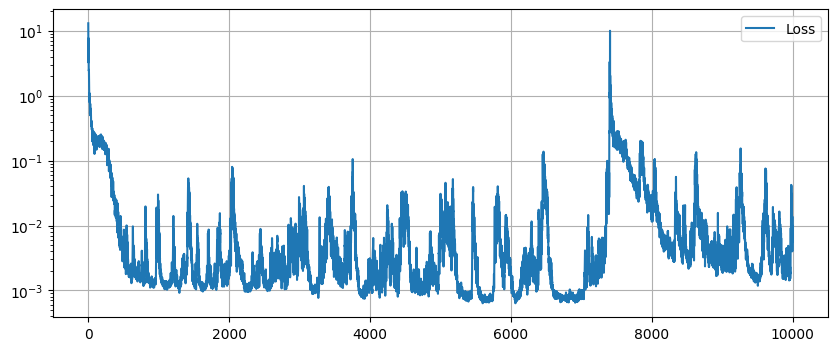

In [44]:
trainer.plot()

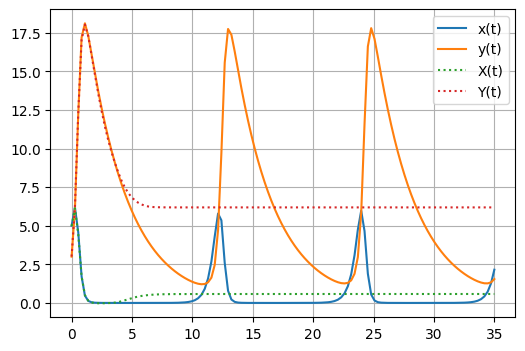

In [45]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig = plt.figure(figsize=(6, 4))

preds = pinn.predict(t.reshape(-1, 1))
plt.plot(t, x, label = 'x(t)')
plt.plot(t, y, label = 'y(t)')
plt.plot(t, preds[:,0].detach(), label='X(t)', linestyle=':')
plt.plot(t, preds[:,1].detach(), label='Y(t)', linestyle=':')
plt.grid()
plt.legend()

plt.show()

In [46]:
from PIL import Image
import imageio
from joblib import Parallel, delayed

from tqdm.notebook import tqdm_notebook as tqdm

def save_animation(files, path, duration=5, fps=60, loop=0, type='mp4', processors=2, ):
    
    fig = plt.figure(figsize=(5, 3))
    xlim = t.min(), t.max()
    
    def plot(i):
        preds = np.load(files[i])
        # Set plot limits and labels
        plt.xlim(xlim)
        plt.plot(t, x, label = 'x(t)')
        plt.plot(t, y, label = 'y(t)')
        plt.plot(t, preds[:,0], label='X(t)', linestyle=':')
        plt.plot(t, preds[:,1], label='Y(t)', linestyle=':')
        plt.grid()
        plt.legend()
        fig.savefig(f'./.temp/frame_{i}.png', dpi=300)
        fig.clear()
        
    # Number of frames
    num_frames = len(files)

    # Parallelize the plotting function
    Parallel(n_jobs=processors, verbose=4)(delayed(plot)(i) for i in range(num_frames))
    
    if type == 'mp4':
        writer = imageio.get_writer(path, fps=fps)
        for i in range(len(files)):
            writer.append_data(imageio.imread(f'./.temp/frame_{i}.png'))
        writer.close()
        
    if type == 'gif':
        imgs = [Image.open(f'./.temp/frame_{i}.png') for i in range(len(files))]
        imgs[0].save(path, save_all=True, append_images=imgs[1:], duration=duration, fps=fps, loop=loop)
    
files = [f'./.temp/lv_{i}.npy' for i in range(0, trainer.iter, save_every)]
save_animation(files, './.results/lotka-volterra animation.gif', type='gif', processors=8)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   10.6s finished


<Figure size 500x300 with 0 Axes>